# Pipeline for BIAPT lab EEG Preprocessing: 
#### inspired by: https://github.com/hoechenberger/pybrain_mne/
#### adapted by: Beatrice PDK, Victoria Sus and Charlotte Maschke, 
#### This pipeline uses MNE Python to preprocess EEG data: Plese go here: 
####                                https://mne.tools/stable/overview/index.html
####  for more documentation on MNE Python

## Setup and import

In [1]:
import matplotlib
#import mne_bids
import pathlib
import mne
import os
import os.path as op
from mne import viz
import numpy as np
import PyQt5
# interactive plotting functions.


from mne.preprocessing import (ICA, create_eog_epochs, create_ecg_epochs,corrmap)
#import openneuro

#from mne_bids import BIDSPath, read_raw_bids, print_dir_tree, make_report

# Ensure Matplotlib uses the Qt5Agg backend, 
# which is the best choice for MNE-Python's 
# interactive plotting functions.
matplotlib.use('Qt5Agg')
%matplotlib qt
import matplotlib.pyplot as plt

### Enter the recording information you want preprocess

In [2]:
ID = "030MW"
task = "sedoff" # "sedon1", "sedoff", "sedon2" 
save_task_as = "sedoff" # "sedon1", "turn01", "sedoff", "turn02", "sedon2"

location = '/Users/Kira/Documents/NET_ICU/Data'
output = '/Users/Kira/Documents/NET_ICU/Analyzed/derivative_standard'
extension = 'mff'

In [3]:
raw_path = f"{location}/sub-{ID}/eeg/sub-{ID}_task-{task}_eeg.{extension}"
raw_path

'/Users/Kira/Documents/NET_ICU/Data/sub-030MW/eeg/sub-030MW_task-sedoff_eeg.mff'

## Load the raw data!

In [4]:
if extension == 'mff':
    raw = mne.io.read_raw_egi(raw_path)
if extension == 'set':
    raw = mne.io.read_raw_eeglab(raw_path)
raw

Reading EGI MFF Header from /Users/Kira/Documents/NET_ICU/Data/sub-030MW/eeg/sub-030MW_task-sedoff_eeg.mff...
    Reading events ...
    Assembling measurement info ...
    Synthesizing trigger channel "STI 014" ...
    Excluding events {sync} ...


<RawMff | signal1.bin, 133 x 611505 (611.5 s), ~184 kB, data not loaded>

# To crop (skip if no crop needed)

In [ ]:
eeg_cropped = raw.crop(tmin = 690.1, tmax = 1364) # in seconds 
eeg_cropped

# Run if no crop needed

In [5]:
eeg_cropped = raw.copy()

## Resample the data to 250

In [6]:
if eeg_cropped.info['sfreq'] != 250:
    resampled = eeg_cropped.resample(250)
else:
    resampled = eeg_cropped.copy()

2 events found
Event IDs: [1 2]
2 events found
Event IDs: [1 2]


### Keep the EEG only

In [7]:
# this is to load EEG. If you want to load other stuff please refer to the website documentation
eeg = resampled.pick_types(eeg = True)
print('Number of channels in EEG:')
len(eeg.ch_names)
#eeg.ch_names

Number of channels in EEG:


129

In [8]:
# change the individual reference channel names to 'VREF' for all subjects (to avoid having different names for reference)
if 'E129' in eeg.ch_names:
    print('REF E129 replaced')
    mne.rename_channels(eeg.info,{'E129':'VREF'})
if 'E1001' in eeg.ch_names:
    print('REF E1001 replaced')
    mne.rename_channels(eeg.info,{'E1001':'VREF'})
if 'Vertex Reference' in eeg.ch_names:
    print('Vertex Reference replaced')
    mne.rename_channels(eeg.info,{'Vertex Reference':'VREF'})

Vertex Reference replaced


## Apply filtering

In [9]:
# load actual data into system (before it was only metadata)
eeg.load_data()
#eeg.load_data()

# filter the data between 0.1 to 50 Hz
eeg_filtered = eeg.filter(l_freq=0.1, h_freq = 50) # 0.1, 50

# notch filter the data for freq =60
eeg_notch = eeg_filtered.copy().notch_filter(freqs= 60)
#eeg_notch = eeg_filtered.copy().notch_filter(freqs= 60, notch_widths = 2.25) # Default notch was not long enough for 027MW

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 8251 samples (33.004 sec)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.4s


Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 59.35
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 59.10 Hz)
- Upper passband edge: 60.65 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 60.90 Hz)
- Filter length: 1651 samples (6.604 sec)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.4s


In [10]:
%matplotlib qt
viz.plot_raw_psd(eeg_notch, exclude = ['VREF'], fmax = 70)
plt.title(ID)
if not os.path.exists('{}/Preprocessing_info/sub-{}'.format(output,ID,save_task_as)) :
    os.makedirs('{}/Preprocessing_info/sub-{}'.format(output,ID,save_task_as))
plt.savefig('{}/Preprocessing_info/sub-{}/sub-{}_task-{}_PSD_raw_filtered.png'.
            format(output,ID,ID,save_task_as))

Effective window size : 8.192 (s)


# Skip if not needed

In [ ]:
#eeg_notch = eeg_notch.copy().notch_filter(freqs= 47) 
#eeg_notch = eeg_notch.copy().notch_filter(freqs= 41.5)

In [ ]:
%matplotlib qt
viz.plot_raw_psd(eeg_notch, exclude = ['VREF'], fmax = 70)
plt.title(ID)
if not os.path.exists('{}/Preprocessing_info/sub-{}'.format(output,ID,save_task_as)) :
    os.makedirs('{}/Preprocessing_info/sub-{}'.format(output,ID,save_task_as))
plt.savefig('{}/Preprocessing_info/sub-{}/sub-{}_task-{}_PSD_raw_filtered2.png'.
            format(output,ID,ID,save_task_as))

## Visualize raw data to identify bad channels

Using matplotlib as 2D backend.


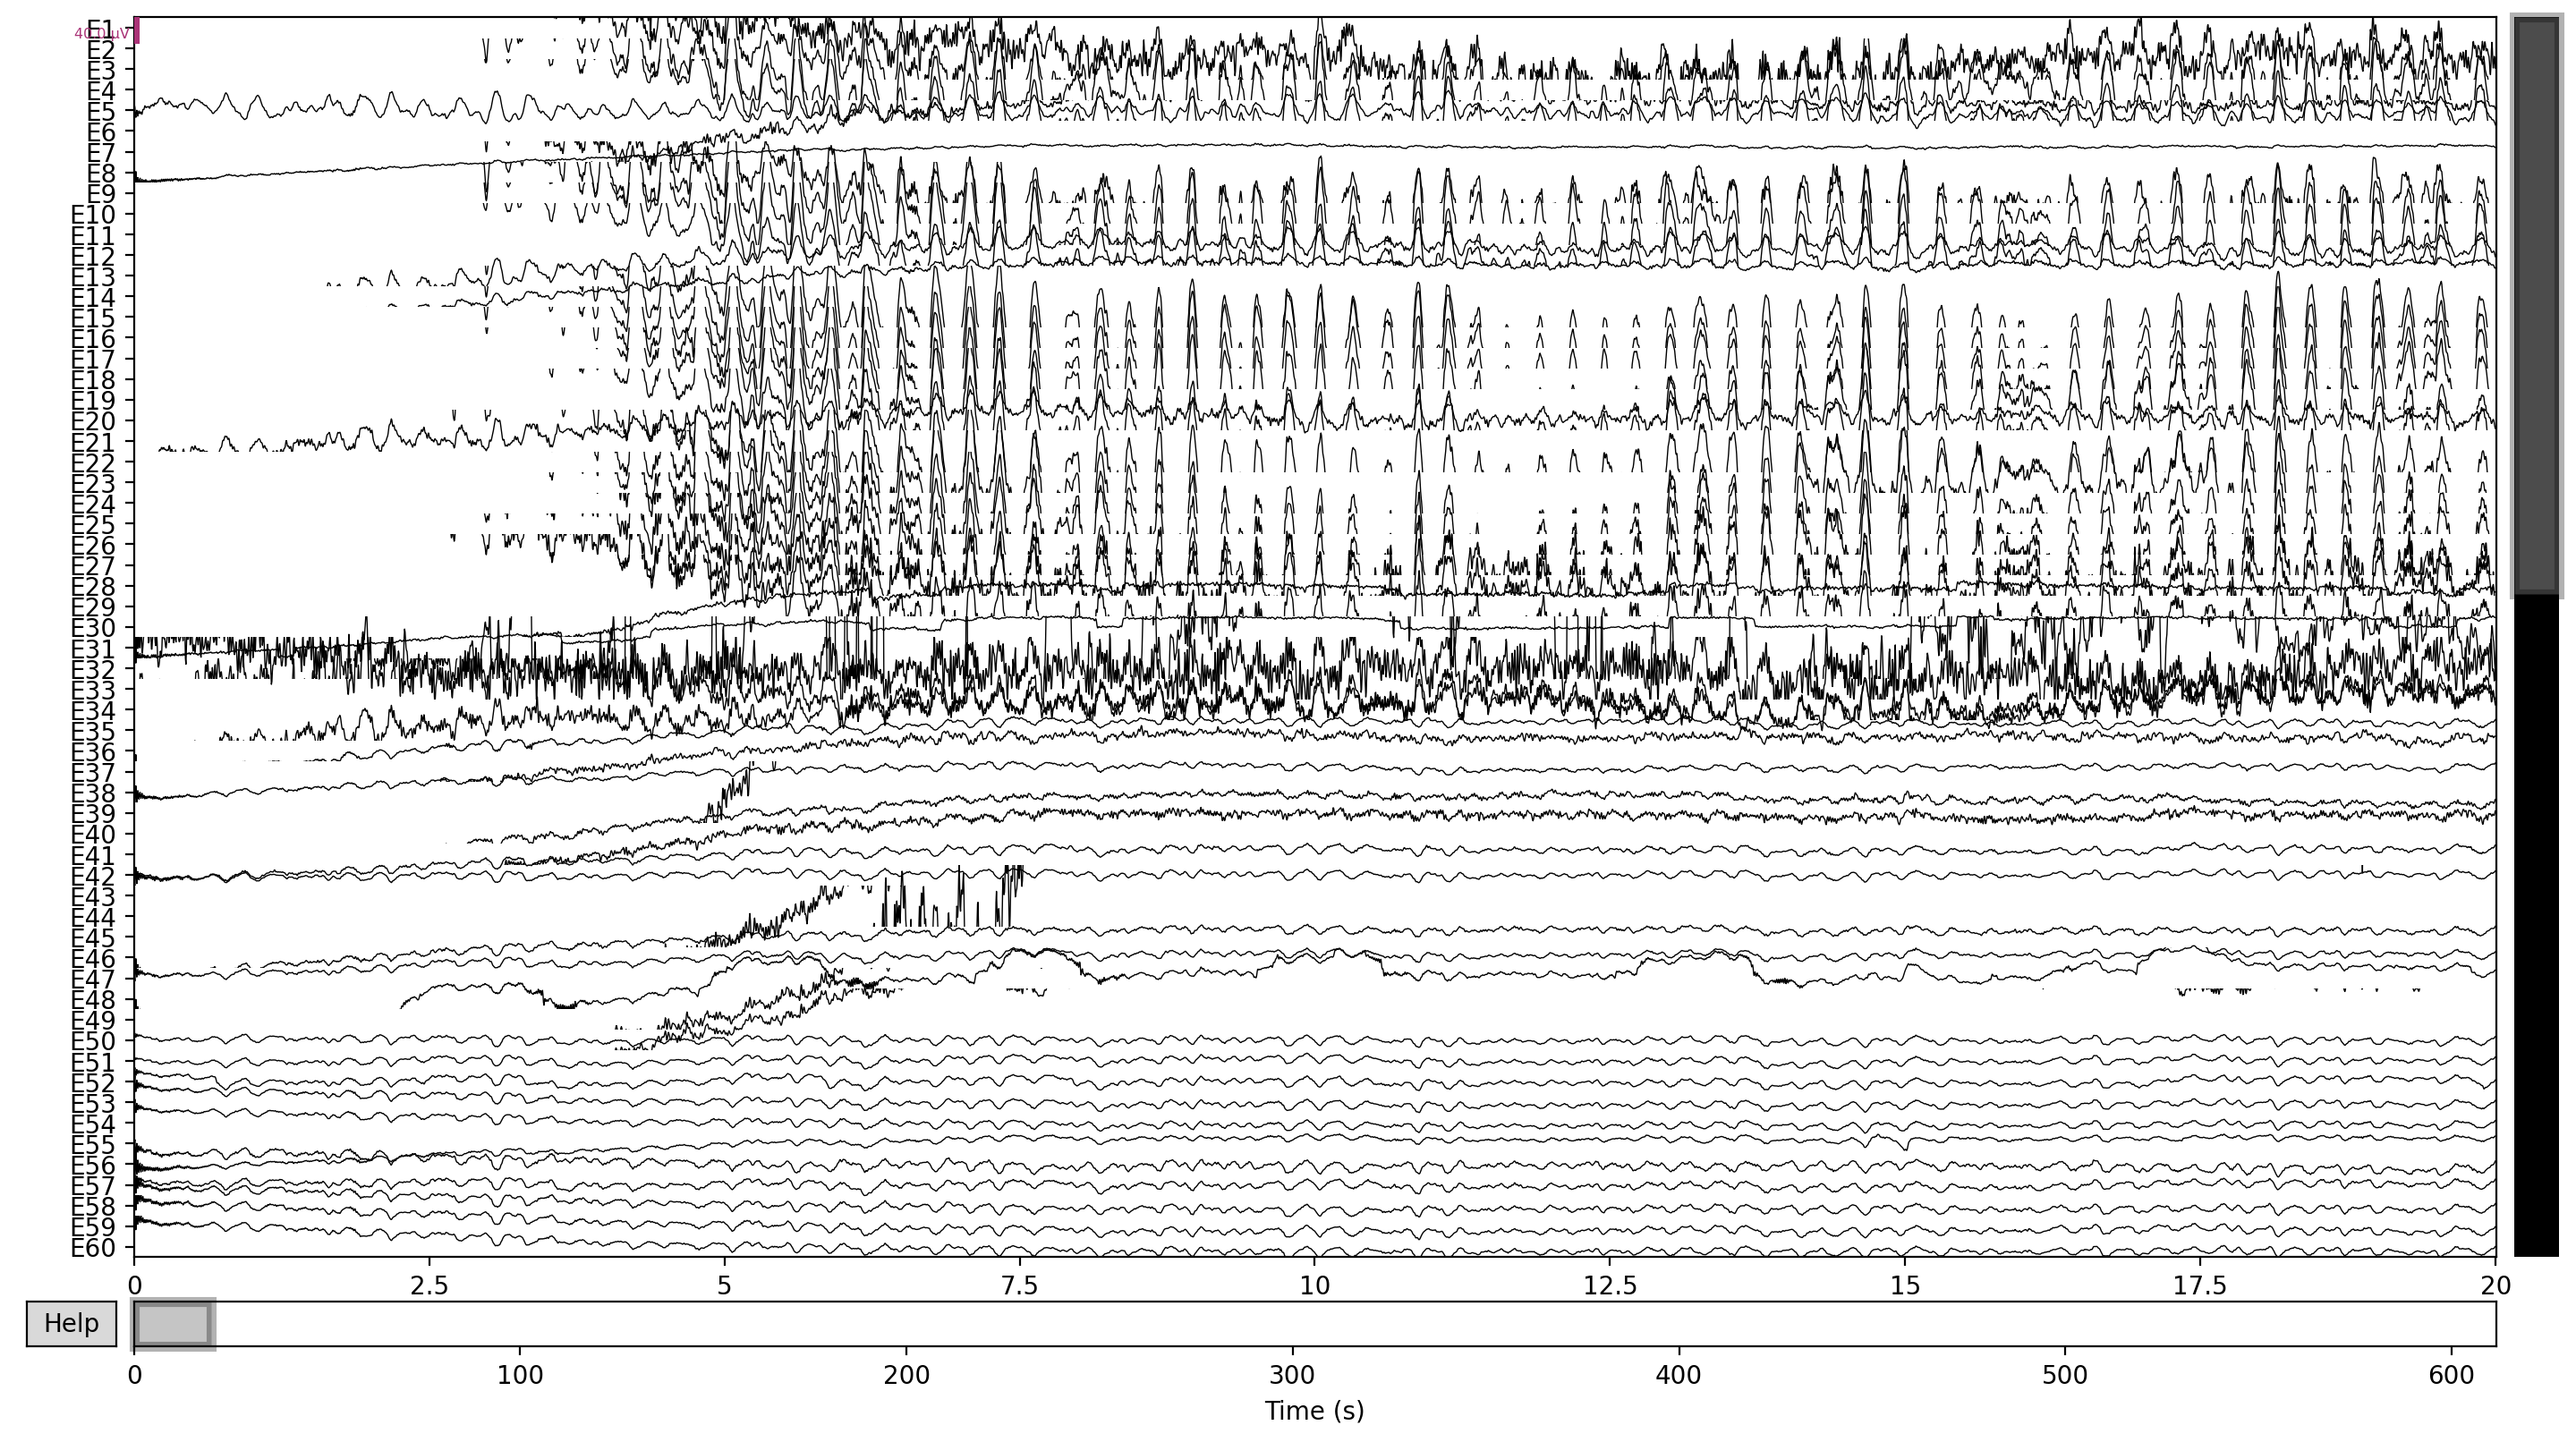

Channels marked as bad:
['E113', 'E114', 'E119', 'E120', 'E128', 'E127', 'E126', 'E125', 'E121', 'E38', 'E43', 'E31', 'E47', 'E32', 'E44']


In [11]:
eeg_notch.plot(n_channels=60, duration=20)

Verify if labelled correctly

In [12]:
marked_bad = eeg_notch.info['bads']
marked_bad

['E113',
 'E114',
 'E119',
 'E120',
 'E128',
 'E127',
 'E126',
 'E125',
 'E121',
 'E38',
 'E43',
 'E31',
 'E47',
 'E32',
 'E44']

In [13]:
# save in a txt
if not os.path.exists('{}/Preprocessing_info/sub-{}'.format(output,ID)) :
    os.makedirs('{}/Preprocessing_info/sub-{}'.format(output,ID))
with open('{}/Preprocessing_info/sub-{}/sub-{}_task-{}_marked_bads.txt'.format(output,ID,ID,save_task_as), 'w') as outfile:
    outfile.write("\n".join(marked_bad))


In [14]:
# just for plotting reasons, we add VREF here. This does not add VREF to the bad channels
bads_tmp = eeg_notch.info['bads'].copy()
bads_tmp.append('VREF')

Effective window size : 8.192 (s)


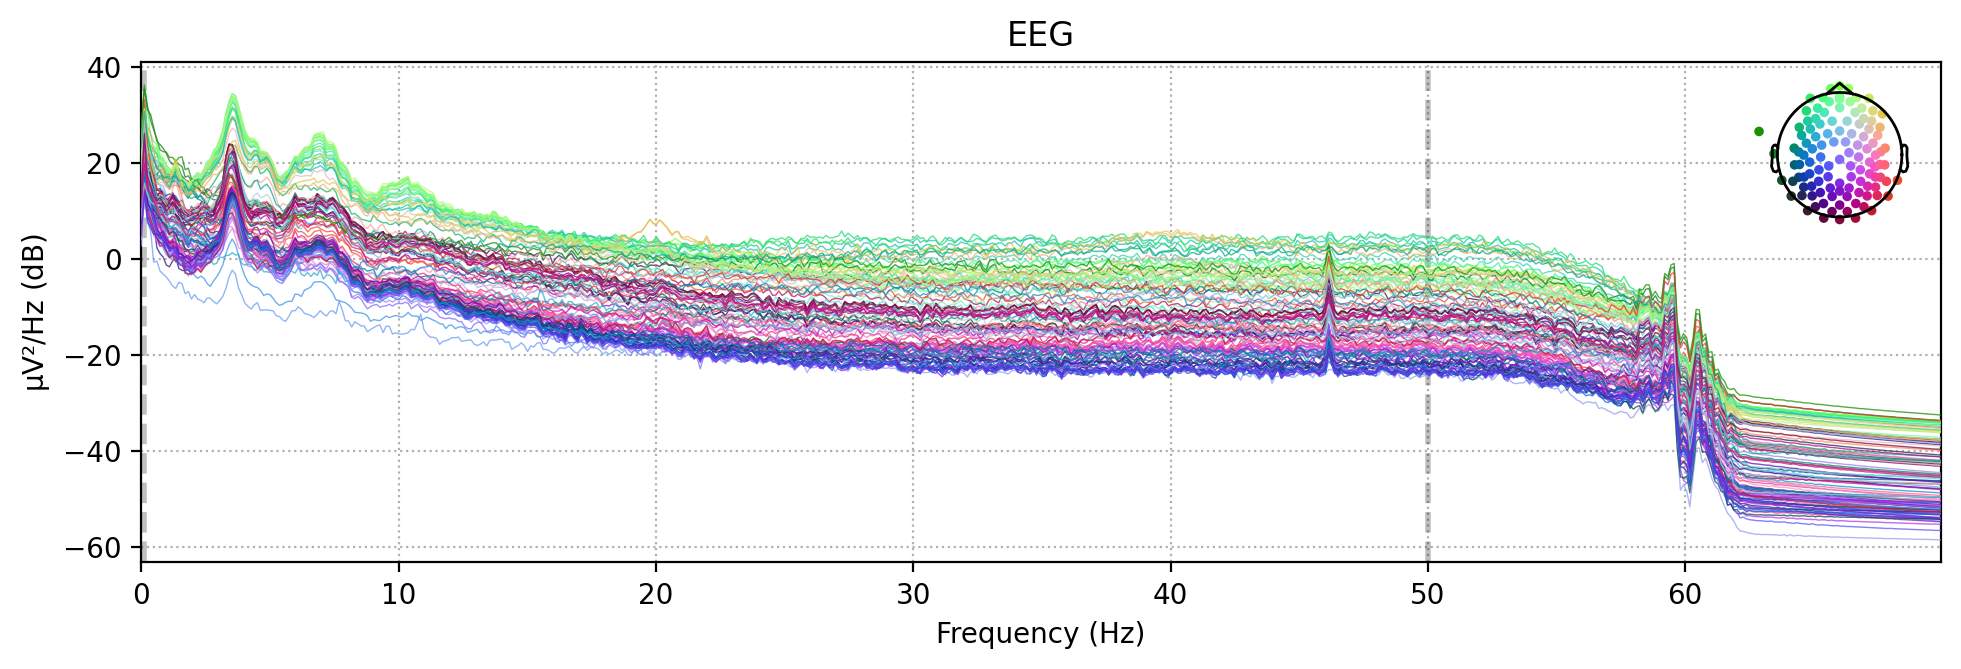

In [15]:
%matplotlib qt
viz.plot_raw_psd(eeg_notch, exclude = bads_tmp, fmax = 70)

## Remove bad channels

In [16]:
eeg_badremoved = eeg_notch.copy().drop_channels(marked_bad)

## Segment into 10-sec epochs

In [17]:
epochs = mne.make_fixed_length_epochs(eeg_badremoved, duration = 10, overlap=0)

Not setting metadata
61 matching events found
No baseline correction applied
0 projection items activated


In [18]:
epochs  #verify initial number

<Epochs |  61 events (good & bad), 0 - 9.996 sec, baseline off, ~166 kB, data not loaded,
 '1': 61>

## Average Reference the data

In [19]:
# use the average of all channels as reference
eeg_avg_ref = epochs.load_data().set_eeg_reference(ref_channels='average')

Using data from preloaded Raw for 61 events and 2500 original time points ...
0 bad epochs dropped
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


## Remove Non-Brain Electrodes 

In [20]:
non_brain_el = ['E127', 'E126', 'E17', 'E21', 'E14', 'E25', 'E8', 'E128', 'E125', 'E43', 'E120', 'E48', 
                'E119', 'E49', 'E113', 'E81', 'E73', 'E88', 'E68', 'E94', 'E63', 'E99', 'E56', 'E107' ]

#only add non-brain channels if not already part of noisy channels
for e in non_brain_el: 
    if e in eeg_avg_ref.info['ch_names']:
        if e not in marked_bad :
            eeg_avg_ref.info['bads'].append(e)
    


In [21]:
print(eeg_avg_ref.info['bads'])

['E17', 'E21', 'E14', 'E25', 'E8', 'E48', 'E49', 'E81', 'E73', 'E88', 'E68', 'E94', 'E63', 'E99', 'E56', 'E107']


In [22]:
# remove non-brain channels
eeg_brainonly = eeg_avg_ref.copy().drop_channels(eeg_avg_ref.info['bads'])

### Reject epochs with amplitude bigger than 2000 µVolt 

Peak to peak amplitude on brain scalp > 2000 µVolt are epochs not linked with physiological causes, physiological amplitude accepted < 800 µVolt

In [23]:
epochs_clean = eeg_brainonly.copy().load_data()
#epochs_clean.drop_bad({'eeg':600*1e-6})
#epochs_clean.plot_drop_log()

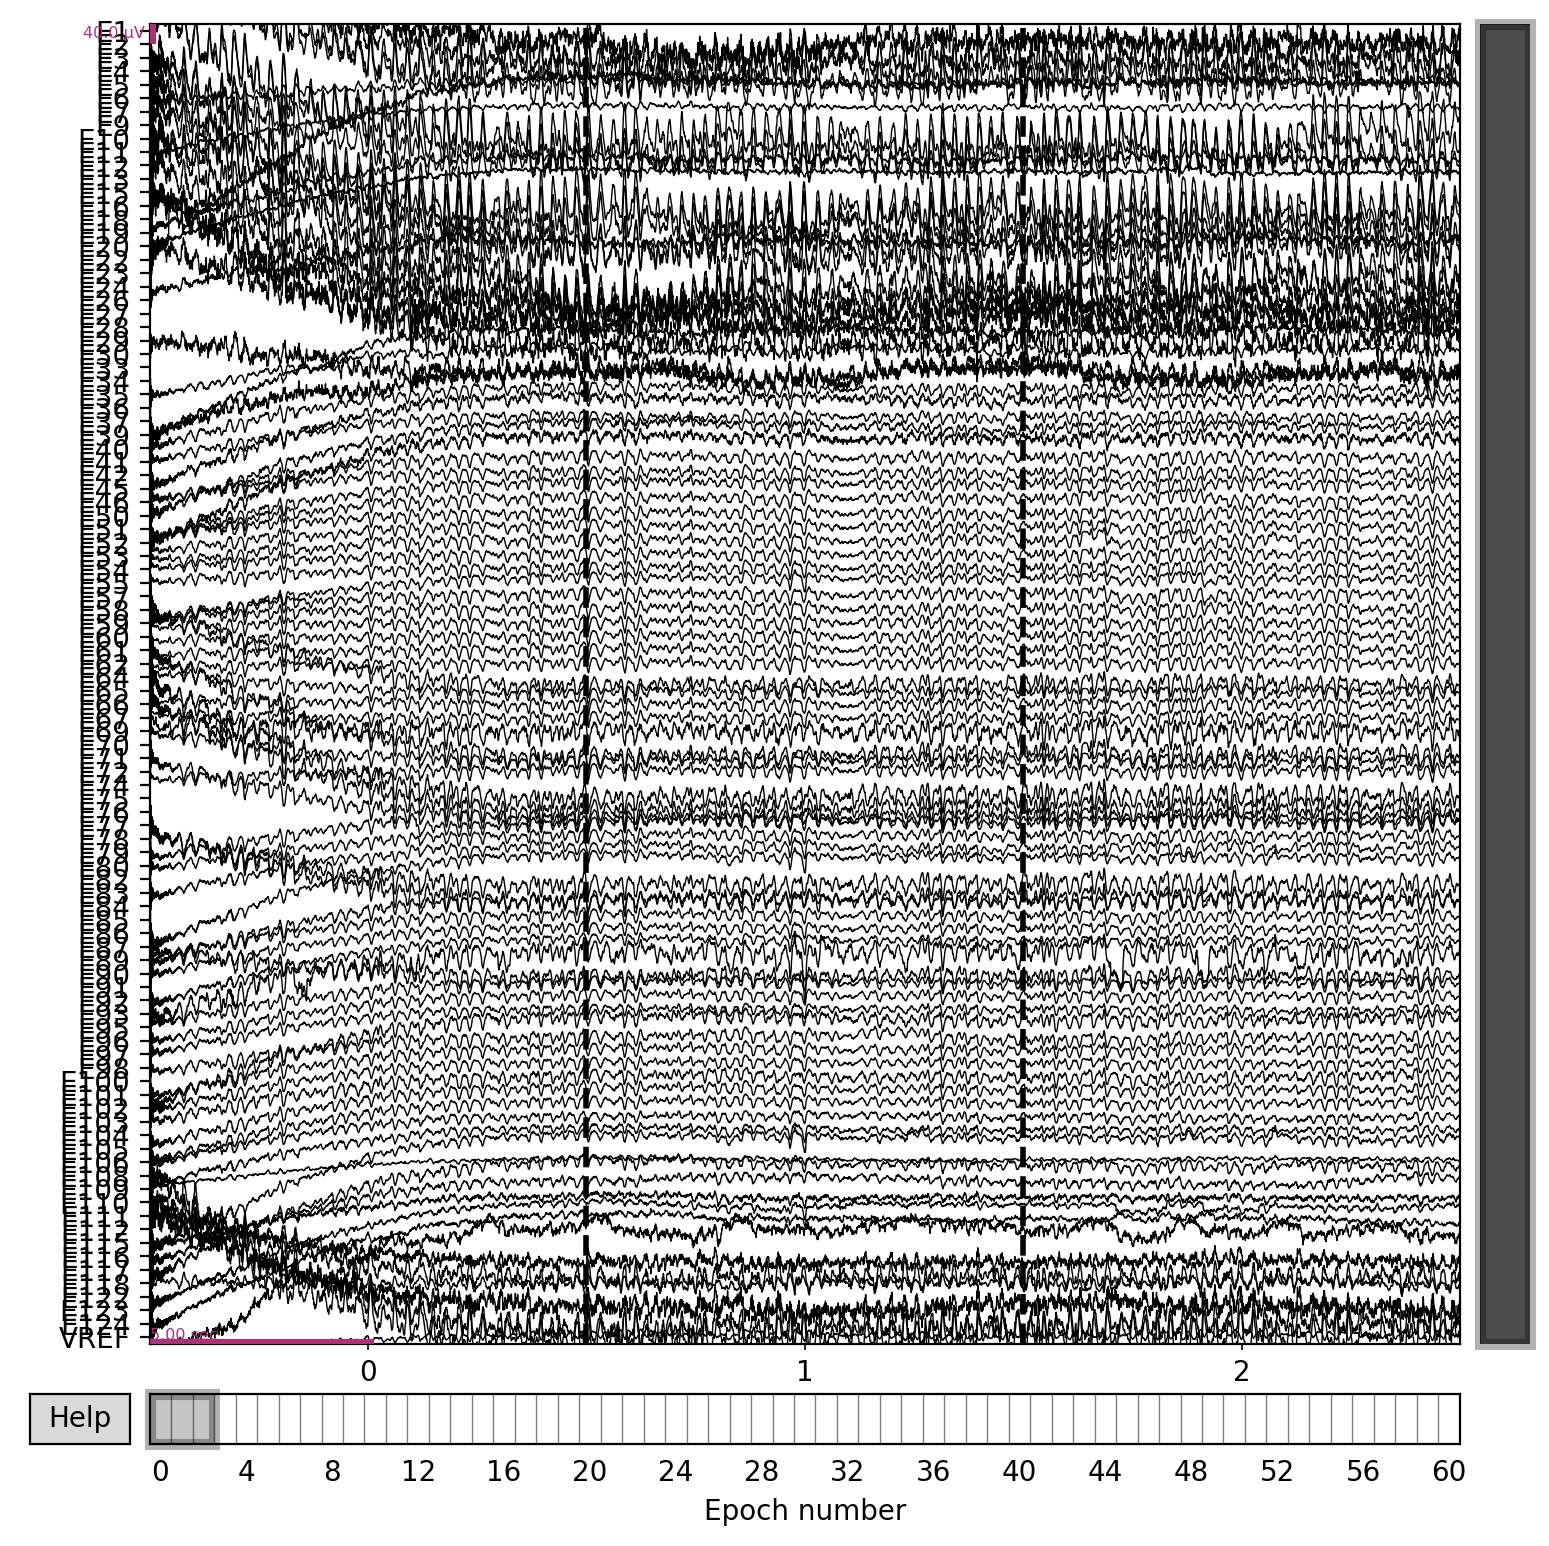

Dropped 2 epochs: 0, 60
The following epochs were marked as bad and are dropped:
[0, 60]
Channels marked as bad:
none


In [24]:
epochs_clean.plot(title='bad_epochs_remaining', n_epochs=3, n_channels=120, scalings=20e-6)

## Check final data

In [25]:
#eeg_brainonly.plot(n_epochs=3, n_channels=100, scalings=20e-6)

In [26]:
epochs_clean

<Epochs |  59 events (all good), 0 - 9.996 sec, baseline off, ~110.4 MB, data loaded,
 '1': 59>

In [27]:
# marked_bad = epochs_clean.info['bads']
# marked_bad

In [28]:
# epochs_clean = epochs_clean.copy().drop_channels(marked_bad)

In [29]:
%matplotlib qt
epochs_clean.plot_psd(fmax=70, exclude = ['VREF'])
plt.title(ID)
if not os.path.exists('{}/Preprocessing_info/sub-{}'.format(output,ID,save_task_as)) :
    os.makedirs('{}/Preprocessing_info/sub-{}'.format(output,ID,save_task_as))
plt.savefig('{}/Preprocessing_info/sub-{}/sub-{}_task-{}_PSD_final.png'.
            format(output,ID,ID,save_task_as))

    Using multitaper spectrum estimation with 7 DPSS windows


In [30]:
# save a list of dropped epochs
dropped_epochs =  [n for n, dl in enumerate(epochs_clean.drop_log) if len(dl)]
dropped_epochs = [str(i) for i in dropped_epochs] # need to convert to str to save
# save in a txt
if not os.path.exists('{}/Preprocessing_info/sub-{}'.format(output,ID)) :
    os.makedirs('{}/Preprocessing_info/sub-{}'.format(output,ID))
with open('{}/Preprocessing_info/sub-{}/sub-{}_task-{}_dropped_epochs.txt'.format(output,ID,ID,save_task_as), 'w') as outfile:
    outfile.write("\n".join(dropped_epochs))

## Save final brain data

In [31]:
# get some summary info
output_summary = {
    "nr_epochs_final": len(epochs_clean),
    "nr_epochs_dropped": len(epochs)-len(epochs_clean),
    "nr_channels_final": len(epochs_clean.info['ch_names']),
    "nr_channels_dropped": 129 - len(non_brain_el)-len(epochs_clean.info['ch_names'])}

with open('{}/Preprocessing_info/sub-{}/sub-{}_task-{}_SUMMARY.txt'.format(output,ID,ID,save_task_as), 'w') as file:
    print(output_summary, file=file)

In [32]:
if not os.path.exists(f'{output}/sub-{ID}/eeg/') :
    os.makedirs(f'/{output}/sub-{ID}/eeg/')

epochs_clean.save(f"/{output}/sub-{ID}/eeg/sub-{ID}_task-{save_task_as}_epoch_eeg.fif", overwrite=True)

/var/folders/k5/_xphllbs0xjbmsdd8yq68rp80000gp/T/ipykernel_1980/1079945510.py:4: RuntimeWarning: This filename (//Users/Kira/Documents/NET_ICU/Analyzed/derivative_standard/sub-030MW/eeg/sub-030MW_task-sedoff_epoch_eeg.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs_clean.save(f"/{output}/sub-{ID}/eeg/sub-{ID}_task-{save_task_as}_epoch_eeg.fif", overwrite=True)


In [33]:
print('End :)')

End :)
